In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
pio.renderers.default = "svg"

from helpers.db_connection import DBConnect

from sklearn.cluster import KMeans

### start by comparing political map

In [2]:
party_state_year_q = """
WITH t AS
(
	SELECT
		s.`state`,
		v.`year`,
		s.`party`,
		COUNT(DISTINCT s.`senator_id`) AS cnt
	FROM senators s
	JOIN votes v ON v.`senator_id` = s.`senator_id`
	GROUP BY s.`state`, v.`year`, s.`party`
)


SELECT 
	m.`state`, 
	m.`year`, 
	CASE WHEN t.cnt=1 THEN 'Tie' ELSE t.`party` END AS party
FROM (
	SELECT
		t.`state`,
		t.`year`,
		max(t.`cnt`) as max_cnt
	FROM t
	GROUP BY t.`state`, t.`year`
) m
JOIN t ON t.`state` = m.`state` 
	AND t.`year` = m.`year` 
	AND m.`max_cnt` = t.`cnt`
;
"""

In [3]:
with DBConnect('senate') as cnx:
    state_parties = pd.read_sql(con=cnx.cnx, sql=party_state_year_q)

In [4]:
state_parties = state_parties.loc[state_parties['party']!='Vice President', :]

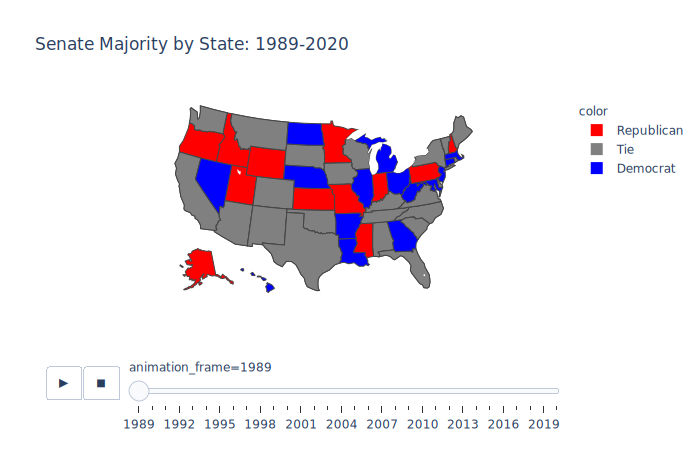

In [5]:
fig = px.choropleth(locations=state_parties['state'], locationmode="USA-states", color=state_parties['party'], 
                    scope="usa", animation_frame=state_parties['year'], 
                    color_discrete_map={'Republican': 'red', 'Democrat': 'blue', 'Independent': 'purple', 'Tie': 'gray'}, title="Senate Majority by State: 1989-2020")
fig.show()

### Compare 1989 to 2020

In [6]:
parties_1989 = state_parties.loc[state_parties['year']==1989, :]
parties_2020 = state_parties.loc[state_parties['year']==2020, :]

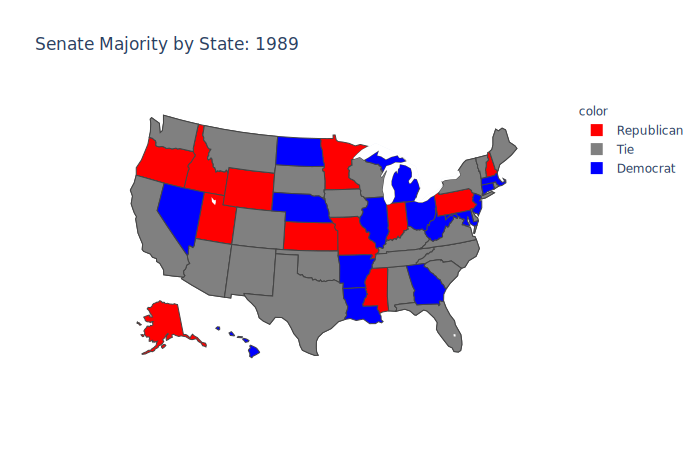

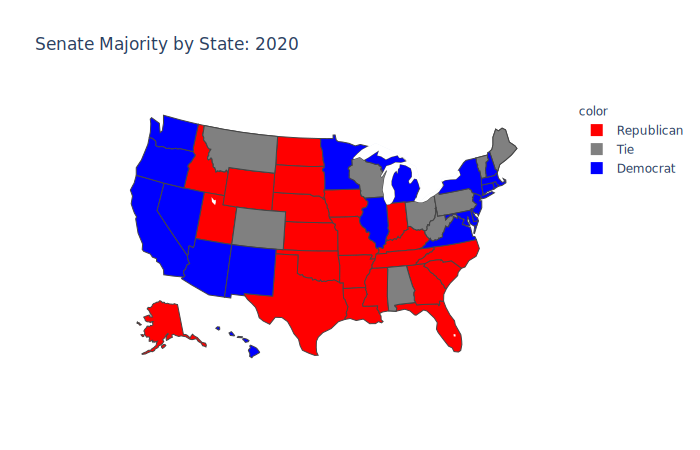

In [7]:
fig = px.choropleth(locations=parties_1989['state'], locationmode="USA-states", color=parties_1989['party'], scope="usa",
                    color_discrete_map={'Republican': 'red', 'Democrat': 'blue', 'Independent': 'purple', 'Tie': 'gray'}, title="Senate Majority by State: 1989")
fig.show()

fig = px.choropleth(locations=parties_2020['state'], locationmode="USA-states", color=parties_2020['party'], scope="usa",
                    color_discrete_map={'Republican': 'red', 'Democrat': 'blue', 'Independent': 'purple', 'Tie': 'gray'}, title="Senate Majority by State: 2020")
fig.show()